In [3]:
from pymongo import MongoClient
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [4]:
baseline_auc = {
    'name': 'baseline',
    0: {0: 0.5441, 2: 0.7340, 4: 0.6161, 6: 0.7392},
    1: {0: 0.6715, 2: 0.6153, 4: 0.8833, 6: 0.7455},
    2: {0: 0.9619, 2: 0.7897, 4: 0.9430, 6: 0.6959},
    3: {1: 0.8136, 2: 0.8597, 3: 0.6330, 4: 0.8445},
    4: {1: 0.7807, 2: 0.6416, 3: 0.7535},
    5: {0: 0.6876, 2: 0.6818, 4: 0.7430, 6: 0.5390}
    }
    
baseline_pauc = {
    'name': 'baseline',
    0: {0: 0.4937, 2: 0.5481, 4: 0.5326, 6: 0.5235},
    1: {0: 0.5674, 2: 0.5810, 4: 0.6710, 6: 0.5802},
    2: {0: 0.8144, 2: 0.6368, 4: 0.7198, 6: 0.4902},
    3: {1: 0.6840, 2: 0.7772, 3: 0.5521, 4: 0.6897},
    4: {1: 0.6425, 2: 0.5601, 3: 0.6103},
    5: {0: 0.5170, 2: 0.5183, 4: 0.5197, 6: 0.4843}
}
    
INVERSE_CLASS_MAP = {
    0: 'fan',
    1: 'pump',
    2: 'slider',
    3: 'ToyCar',
    4: 'ToyConveyor',
    5: 'valve'
}

TRAINING_ID_MAP = {
    0: [0, 2, 4, 6],
    1: [0, 2, 4, 6],
    2: [0, 2, 4, 6],
    3: [1, 2, 3, 4],
    4: [1, 2, 3],
    5: [0, 2, 4, 6]
}

In [58]:
def get_experiment(runs, name, metric='auroc_mean'):
    experiment_dict = dict()
    for i in range(6):
        experiment_dict[i] = dict()
    
    experiment_dict['name'] = name
    experiment_dict['metric'] = metric
    
    for experiment in runs:
        if experiment['config'].get('descriptor') == name:
            machine_dict = experiment_dict.get(experiment['config']['machine_type'])
            result = experiment.get('result')
            if result:
                machine_dict[experiment['config']['machine_id']] = experiment.get('result').get(metric)
            else:
                machine_dict[experiment['config']['machine_id']] = 1
    return experiment_dict


def get_record(experiment):
    record = [experiment['name']]
    for i in range(6):
        for j in TRAINING_ID_MAP[i]:
            if experiment['name'] == 'not_normalized' and i ==3 and j == 4 and experiment['metric'] == 'auroc_mean':
                record.append(0.9975)
            elif experiment['name'] == 'not_normalized' and i ==3 and j == 4 and experiment['metric'] == 'pauroc_mean':
                record.append(0.9867)
            else:
                v = experiment.get(i)
                if v:
                    v = v.get(j, 1)
                else:
                    v = 1
                record.append(v)
    assert len(record) == 24
    return  record

In [13]:
client = MongoClient('mongodb://student2.cp.jku.at:27017/')
db = client.dcase2020_task2
db.list_collection_names()

runs = db.runs.find({
             "experiment.name": "dcase2020_task2_classification"
            })
runs = [r for r in runs]

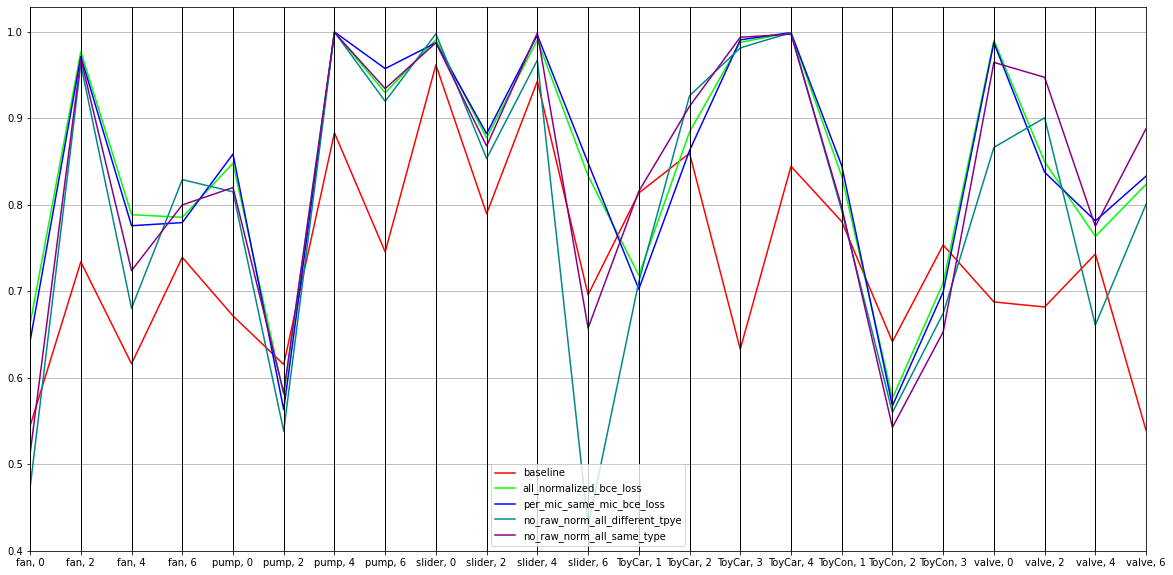

In [14]:
data = [
    get_record(baseline_auc),
    #get_record(get_experiment(runs, 'per_mic_norm_same_mic_comp', metric='auroc_mean')),
    #get_record(get_experiment(runs, 'per_mic_normalized', metric='auroc_mean')),
    #get_record(get_experiment(runs, 'not_normalized', metric='auroc_mean')),
    #get_record(get_experiment(runs, 'no_raw_no_normalization', metric='auroc_mean')),
    get_record(get_experiment(runs, 'all_normalized_bce_loss', metric='auroc_mean')),
    get_record(get_experiment(runs, 'per_mic_same_mic_bce_loss', metric='auroc_mean')),
    get_record(get_experiment(runs, 'no_raw_norm_all_different_tpye', metric='auroc_mean')),
    get_record(get_experiment(runs, 'no_raw_norm_all_same_type', metric='auroc_mean'))
    # no_raw_norm_all_different_tpye
]


df = pd.DataFrame(data)

plt.figure(figsize=(20,10))
pd.plotting.parallel_coordinates(df, 0, color=('#FF0000', '#00FF00', '#0000FF', '#008888', '#880088', '#888800', '#880000'))
labels = []
for i in range(6):
    for j in TRAINING_ID_MAP[i]:
        labels.append("{}, {}".format(INVERSE_CLASS_MAP[i][:6], j))
plt.xticks(np.arange(0, 23), labels)
plt.legend(loc='lower center')
plt.show()

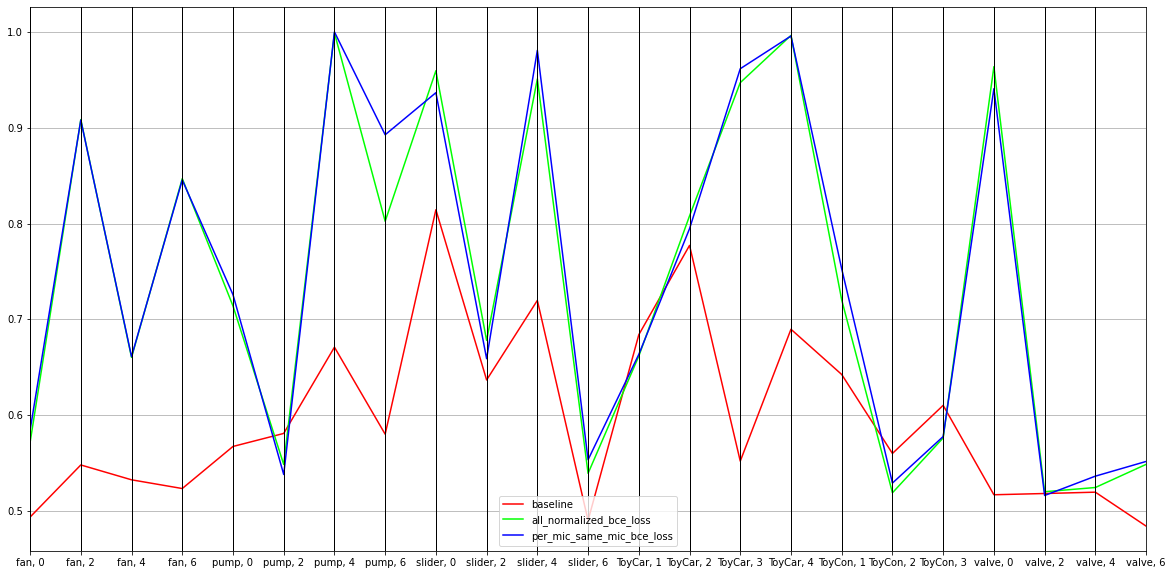

In [15]:
data = [
    get_record(baseline_pauc),
    #get_record(get_experiment(runs, 'per_mic_norm_same_mic_comp', metric='pauroc_mean')),
    #get_record(get_experiment(runs, 'per_mic_normalized', metric='pauroc_mean')),
    #get_record(get_experiment(runs, 'not_normalized', metric='pauroc_mean')),
    #get_record(get_experiment(runs, 'no_raw_no_normalization', metric='pauroc_mean')),
    get_record(get_experiment(runs, 'all_normalized_bce_loss', metric='pauroc_mean')),
    get_record(get_experiment(runs, 'per_mic_same_mic_bce_loss', metric='pauroc_mean'))
]

df = pd.DataFrame(data)

plt.figure(figsize=(20,10))
pd.plotting.parallel_coordinates(df, 0, color=('#FF0000', '#00FF00', '#0000FF', '#008888', '#880088', '#888800', '#880000'))
plt.legend(loc='lower center')
labels = []
for i in range(6):
    for j in TRAINING_ID_MAP[i]:
        labels.append("{}, {}".format(INVERSE_CLASS_MAP[i][:6], j))
plt.xticks(np.arange(0, 23), labels)
plt.show()

In [49]:

client = MongoClient('mongodb://student2.cp.jku.at:27017/')
db = client.dcase2020_2
db.list_collection_names()

baseline_runs = [r for r in db.runs.find({
             "experiment.name": "dcase2020_task2_baseline"
            })]

classification_runs = [r for r in db.runs.find({
             "experiment.name": "dcase2020_task2_classification"
            })]

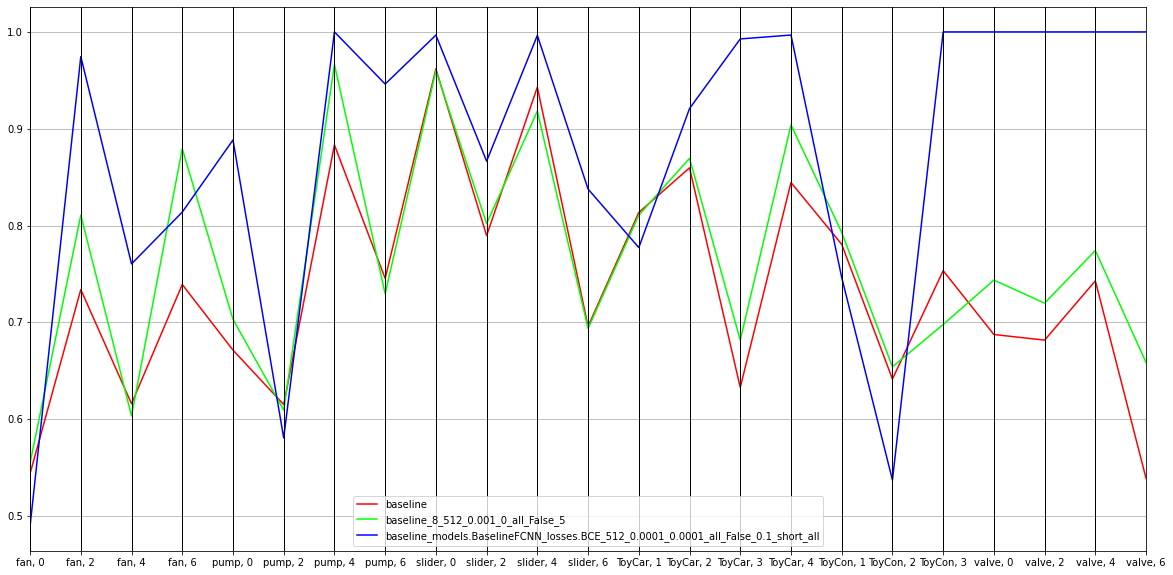

In [59]:
data = [
    get_record(baseline_auc),
    #get_record(get_experiment(runs, 'per_mic_norm_same_mic_comp', metric='pauroc_mean')),
    #get_record(get_experiment(runs, 'per_mic_normalized', metric='pauroc_mean')),
    #get_record(get_experiment(runs, 'not_normalized', metric='pauroc_mean')),
    #get_record(get_experiment(runs, 'no_raw_no_normalization', metric='pauroc_mean')),
    #get_record(get_experiment(runs, 'all_normalized_bce_loss', metric='pauroc_mean')),
    get_record(get_experiment(baseline_runs, 'baseline_8_512_0.001_0_all_False_5', metric='auroc_mean')),
    get_record(get_experiment(classification_runs, 'baseline_models.BaselineFCNN_losses.BCE_512_0.0001_0.0001_all_False_0.1_short_all', metric='auroc_mean'))
]

df = pd.DataFrame(data)

plt.figure(figsize=(20,10))
pd.plotting.parallel_coordinates(df, 0, color=('#FF0000', '#00FF00', '#0000FF', '#008888', '#880088', '#888800', '#880000'))
plt.legend(loc='lower center')
labels = []
for i in range(6):
    for j in TRAINING_ID_MAP[i]:
        labels.append("{}, {}".format(INVERSE_CLASS_MAP[i][:6], j))
plt.xticks(np.arange(0, 23), labels)
plt.show()

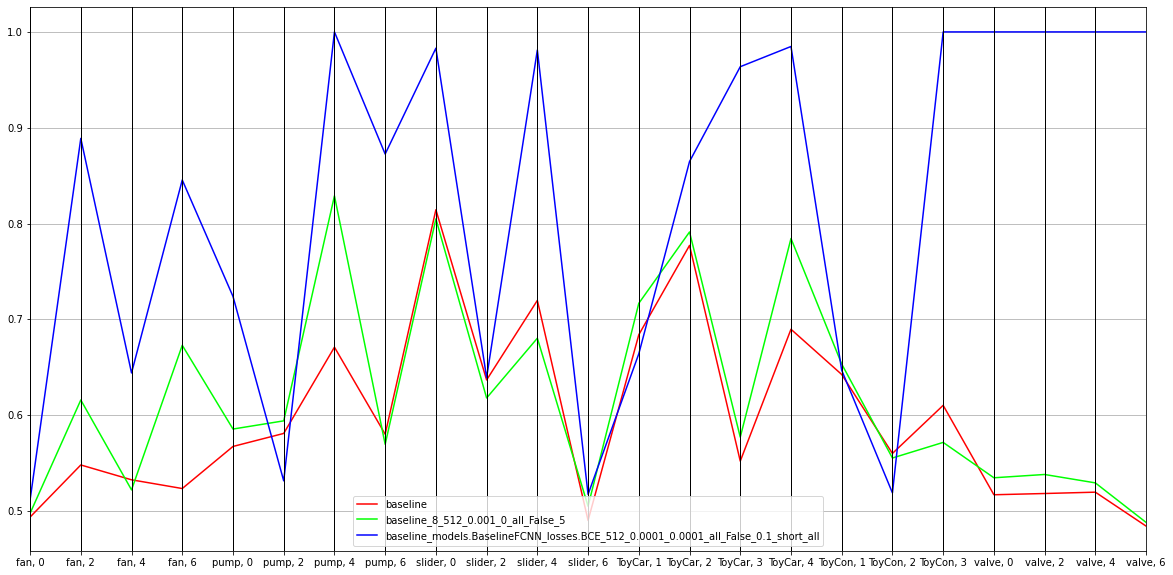

In [60]:
data = [
    get_record(baseline_pauc),
    #get_record(get_experiment(runs, 'per_mic_norm_same_mic_comp', metric='pauroc_mean')),
    #get_record(get_experiment(runs, 'per_mic_normalized', metric='pauroc_mean')),
    #get_record(get_experiment(runs, 'not_normalized', metric='pauroc_mean')),
    #get_record(get_experiment(runs, 'no_raw_no_normalization', metric='pauroc_mean')),
    #get_record(get_experiment(runs, 'all_normalized_bce_loss', metric='pauroc_mean')),
    get_record(get_experiment(baseline_runs, 'baseline_8_512_0.001_0_all_False_5', metric='pauroc_mean')),
    get_record(get_experiment(classification_runs, 'baseline_models.BaselineFCNN_losses.BCE_512_0.0001_0.0001_all_False_0.1_short_all', metric='pauroc_mean'))
]

df = pd.DataFrame(data)

plt.figure(figsize=(20,10))
pd.plotting.parallel_coordinates(df, 0, color=('#FF0000', '#00FF00', '#0000FF', '#008888', '#880088', '#888800', '#880000'))
plt.legend(loc='lower center')
labels = []
for i in range(6):
    for j in TRAINING_ID_MAP[i]:
        labels.append("{}, {}".format(INVERSE_CLASS_MAP[i][:6], j))
plt.xticks(np.arange(0, 23), labels)
plt.show()


